# Intuition

We are provided with the information that a certain interval $0\leq t_1 < t_2 \leq T$ is corrupted in terms of the covariance structure of the data. This implies that there are *two* distinct points of regime change exactly at $t_1$ and $t_2$: from the regular state to corrupted state at $t_1$, and back to the regular state from the corrupted state at $t_2$.

In the context of principal component analysis, consider that when the data feed enters corrupted state at $t_1$, certain covariance metric of the first few principal components should change in a drastic fashion. In the same logic, the reversed metric time series from $T$ to $t_2$, should as well experience such drastic change from the final regular state to the previous corrupted state.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

def pca_power(matrix, n, max_iter=1000, tolerance=1e-10):
    it = 0
    oldnormw = 0.
    v = np.random.random(n)
    w = np.zeros(n)
    
    while it < max_iter:
        w = matrix.dot(v)
        normw = (np.inner(w,w))**.5
        v = w/normw
        if np.abs(normw - oldnormw)/normw < tolerance:
            break
        oldnormw = normw
        it += 1
    return normw, v

def pca_power_full(matrix, n, max_iter=1000, tolerance=1e-10, n_components=10):
    vals = np.zeros(n_components)
    vecs = np.zeros((n_components, n))
    for i in range(n_components):
        val, vec = pca_power(matrix, n, max_iter, tolerance)
        matrix -= val * np.outer(vec, vec)
        vals[i] = val
        np.copyto(vecs[i], vec)
    return vals, vecs   

def read_data(data_dir:str = "../data/", filename="polluteddeltas.csv") -> np.ndarray:
    filename = data_dir + filename
    f = open(filename,'r')
    csvf = csv.reader(f)
    polluteddeltalist = list(csvf)
    f.close() 
    plist = np.array(polluteddeltalist)
    polluteddata = plist.astype(float) 
    return polluteddata

In [2]:
d = read_data()[:,1:]
d.shape

(1709, 30)

# Heuristics

Explained variance ratio:
[8.33667549e-01 8.27616090e-02 2.69956589e-02 1.50888785e-02
 9.53845342e-03 6.44772351e-03 4.75713392e-03 3.86143962e-03
 2.83758326e-03 1.88153622e-03 1.56894934e-03 1.38314769e-03
 1.19946798e-03 9.61661007e-04 8.42107504e-04 7.90898497e-04
 7.28218084e-04 5.90822047e-04 5.44982339e-04 5.07637406e-04
 4.60027937e-04 4.40135097e-04 3.89222687e-04 3.56094759e-04
 3.37163409e-04 3.07189516e-04 2.90735606e-04 2.38327797e-04
 2.25645554e-04 3.04925229e-13]

Leading eigenvalue:
2279.659932349567


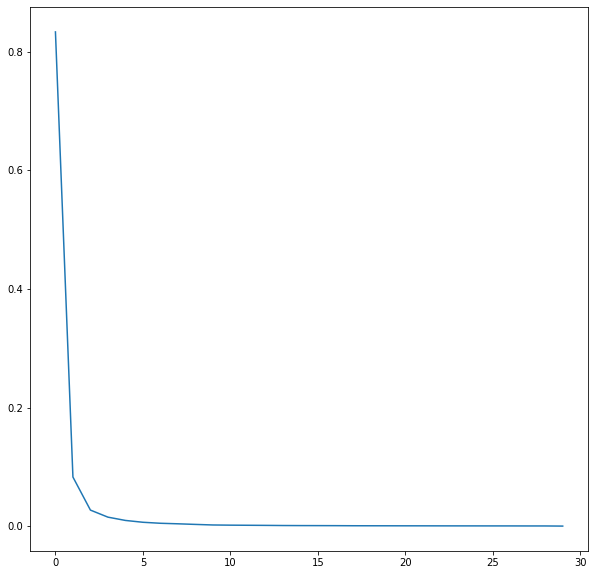

In [3]:
cov = np.cov(d[:200].T)
vals, vecs = pca_power_full(cov, d.shape[1], n_components=30)

print("Explained variance ratio:")
evr = vals / vals.sum()
print(evr)
print()
print("Leading eigenvalue:")
eig1 = vals[0]
print(eig1)
fig, ax = plt.subplots(1,1,figsize = [10, 10])
ax.plot(evr)

In [125]:
n_components = 1
T, k = d.shape
w = 500
dt = 1

eigs = np.zeros((T, n_components))
evrs = np.zeros((T, n_components))
vecs = np.zeros((T, k))

for t in range(0, T-w, dt):
    cov = np.cov(d[t:t+w].T)
    eigs[t], vecs[t] = pca_power_full(cov, k, n_components=n_components)


    

# Leading Eigenvector Inner Product Tracer

In [143]:
key = 100

innerprods = np.zeros(T-w)
for i in range(0, T-w, dt):
    innerprods[i] = np.abs(
        np.inner(vecs[key], vecs[i])
    )

Text(0.5, 1.0, 'Inner Products with key = 100')

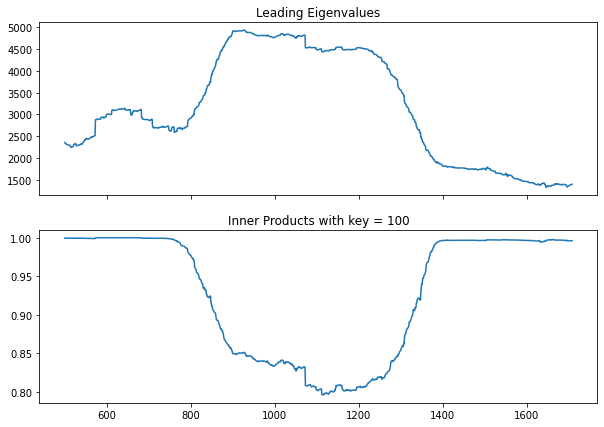

In [145]:
fig, ax = plt.subplots(2,1,figsize = [10,7], sharex=True)

ax[0].plot(np.arange(w, T, dt), eigs[eigs!=0])
ax[1].plot(np.arange(w, T, dt), innerprods)

ax[0].set_title("Leading Eigenvalues")
ax[1].set_title(f"Inner Products with key = {key}")

### Use distribution rule to determine first occurrence of outlier:

Usually, the inner products should be 1. When the metric drifts away from 1, we say that the data feed has entered the corrupted state.

In [106]:
# forward and backward reference

baseline_1 = innerprods[:100]
baseline_2 = innerprods[-100:]
k = 3

# forward and backward first occurrence
thresh_1 = baseline_1.mean() - k * baseline_1.std()
thresh_2 = baseline_2.mean() - k * baseline_2.std()
print("t1:", (innerprods<thresh_1).argmax() + w)
print("t2:", T - ((innerprods[::-1] < thresh_2).argmax() + w))

t1: 755
t2: 888


In [135]:
N = 100
result = np.zeros((N, 2))

for key in range(N):

    innerprods = np.zeros(T-w)
    for i in range(0, T-w, dt):
        innerprods[i] = np.abs(
            np.inner(vecs[key], vecs[i])
        )

    baseline_1 = innerprods[:100]
    baseline_2 = innerprods[-100:]
    k = 5

    # forward and backward first occurrence
    thresh_1 = baseline_1.mean() - k * baseline_1.std()
    thresh_2 = baseline_2.mean() - k * baseline_2.std()
    t1 = (innerprods<thresh_1).argmax() + w
    t2 = T - ((innerprods[::-1] < thresh_2).argmax() + w)

    result[key] = t1, t2


### Period [$t_1$, $t_2$] as determined using inner product method:

In [138]:
period = result.mean(axis = 0).astype(int)
print("t1:", period[0])
print("t2:", period[1])

t1: 742
t2: 890


# Leading Eigenvector L2 Norm Tracer

In [30]:
key = 141

l2 = ((vecs - vecs[key])**2).sum(axis = 1)[:T-w]

Text(0.5, 1.0, 'L2 Norm with key = 141')

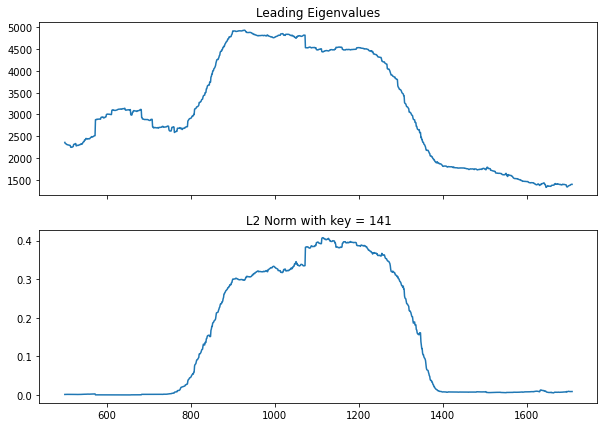

In [31]:
fig, ax = plt.subplots(2,1,figsize = [10,7], sharex=True)

ax[0].plot(np.arange(w, T, dt), eigs[eigs!=0])
ax[1].plot(np.arange(w, T, dt), l2)

ax[0].set_title("Leading Eigenvalues")
ax[1].set_title(f"L2 Norm with key = {key}")


### Use distribution rule to determine first occurrence of outlier

Usually, the L2 norm should be around 0. When the metric drifts away from 0, we say that the data feed has entered the corrupted state.

In [107]:
# forward and backward reference

baseline_1 = l2[:100]
baseline_2 = l2[-100:]
k = 5

# forward and backward first occurrence
thresh_1 = baseline_1.mean() + k * baseline_1.std()
thresh_2 = baseline_2.mean() + k * baseline_2.std()
print("t1:", (l2 > thresh_1).argmax() + w)
print("t2:", T - ((l2[::-1] > thresh_2).argmax()+w))

t1: 746
t2: 893


In [140]:
N = 100
result = np.zeros((N, 2))

for key in range(N):

    l2 = ((vecs - vecs[key])**2).sum(axis = 1)[:T-w]

    baseline_1 = l2[:100]
    baseline_2 = l2[-100:]
    k = 5

    # forward and backward first occurrence
    thresh_1 = baseline_1.mean() + k * baseline_1.std()
    thresh_2 = baseline_2.mean() + k * baseline_2.std()
    t1 = (l2 > thresh_1).argmax() + w
    t2 = T - ((l2[::-1] > thresh_2).argmax()+w)

    result[key] = t1, t2


### Period [$t_1$, $t_2$] as determined using L2 Norm method:

In [141]:
period = result.mean(axis = 0).astype(int)
print("t1:", period[0])
print("t2:", period[1])

t1: 742
t2: 890
